# Final Project

In [2]:
import serial, time

## Data Collection
Run below cells to collect twitch data

In [3]:
resolution = 100
duration = 10

# Setup Serial Communication
ser = serial.Serial('COM4') # TODO: Check if correct COM/TTYL port
ser.baudrate = 9600
start_time = time.time()

# Start Data Logging
f = open('{0}.txt'.format(start_time), "w")
while True:
    curr_time = time.time()
    if (curr_time - start_time > duration):
        break
    ser.write(str.encode('l'))
    f.write(str(ser.readline()))
ser.close()
f.close()


## Model Fitting
https://www.tensorflow.org/lite/microcontrollers 

https://github.com/tensorflow/decision-forests

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.utils

#### Load and Preprocess Data

In [9]:
def load_data(file_num, path=''):
    motion_file = f'{path}/motion/{file_num}_acceleration.txt'
    sleep_file  = f'{path}/labels/{file_num}_labeled_sleep.txt'
    motion_data = pd.read_csv(motion_file, delimiter=' ', names=['time', 'x', 'y', 'z'])
    sleep_data  = pd.read_csv(sleep_file, delimiter=' ', names=['time', 'label'])
    return motion_data, sleep_data

def assign_sleep_to_motion(motion, sleep):
    labels = []
    index = 0
    for t in range(len(motion)):
        if (t > sleep['time'][index]):
            index += 1
        labels.append(sleep['label'][index])
    data = np.array([motion['time'], motion['x'], motion['y'], motion['z'], labels]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def match_motion_to_sleep(motion, sleep):
    _, _, indices = np.intersect1d(sleep['time'], motion['time'], return_indices=True)
    data = np.array([sleep['time'], 
                    motion['x'][indices], 
                    motion['y'][indices], 
                    motion['z'][indices], 
                    sleep['label']]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z', 'label'])
    df = df.loc[df['label'] > -1]
    return df

def get_motion_average(motion):
    motion_time = np.clip(np.floor(motion['time']), min(sleep['time']), max(sleep['time']))
    motion_time, motion_indices = np.unique(motion_time, return_index=True)
    avg_x = np.array([np.average(motion['x'][i]) for i in motion_indices])
    avg_y = np.array([np.average(motion['y'][i]) for i in motion_indices])
    avg_z = np.array([np.average(motion['z'][i]) for i in motion_indices])
    data = np.array([motion_time, avg_x, avg_y, avg_z]).T
    df = pd.DataFrame(data, columns=['time', 'x', 'y', 'z'])
    return df

def plot_data(df, title=''):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_title(title)
    plot = lambda d, c, m : ax.scatter3D(d['x'], d['y'], d['z'], c=c, marker=m)
    colors = ['r', 'm', 'y', 'g', 'b', 'c']
    [plot(df.loc[df['label'] == i], colors[i], '.') for i in range(6)]
    

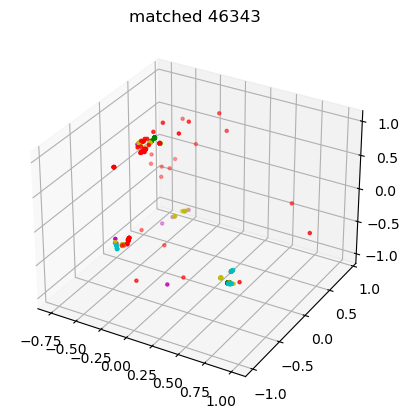

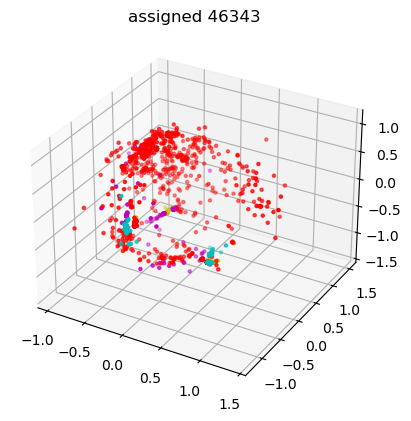

In [10]:
path = './data'
file_nums = ['46343', '1066528', '781756']

motion, sleep = load_data(file_nums[0], './data')

avg_motion = get_motion_average(motion)

matched_time_data_average_df = match_motion_to_sleep(avg_motion, sleep)
assigned_time_data_average_df = assign_sleep_to_motion(avg_motion, sleep)

plot_data(matched_time_data_average_df, f'matched {file_nums[0]}')
plot_data(assigned_time_data_average_df, f'assigned {file_nums[0]}')

def load_all(file_nums, path='', func=None):
    for num in file_nums:
        motion, sleep = load_data(num, path)
        motion, sleep = func(motion), func(sleep)

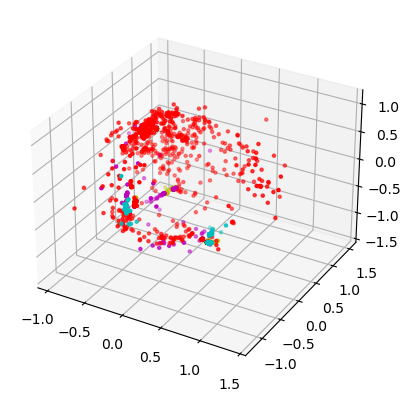

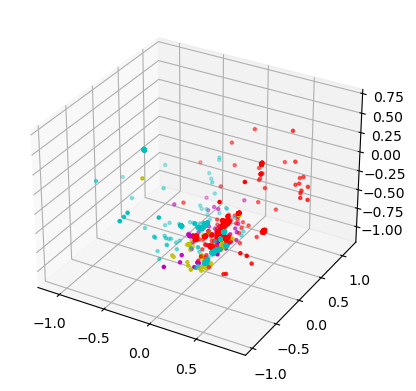

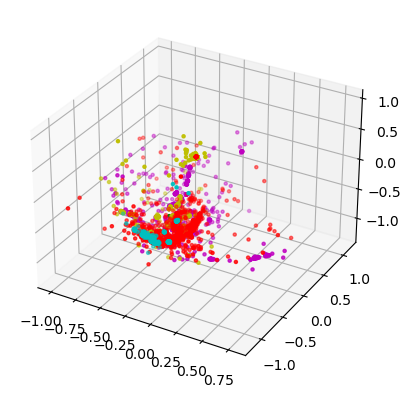

In [11]:
data = [load_data(file_nums[i], './data') for i in range(3)]
prep_func = lambda d: assign_sleep_to_motion(get_motion_average(d[0]), d[1])
train_data, valid_data, test_data = [sklearn.utils.shuffle(prep_func(d)) for d in data]
[plot_data(d) for d in (train_data, valid_data, test_data)]
x_train, x_valid, x_test = [np.array([d['x'], d['y'], d['z']]).T for d in (train_data, valid_data, test_data)]
y_train, y_valid, y_test  = [d['label'] for d in (train_data, valid_data, test_data)]

#### Train Model

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [19]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
%%capture
# Simple Neural Network
model = tf.keras.Sequential()
model.add(keras.layers.Dense(8, activation='relu', input_shape=(3,)))
model.add(keras.layers.Dense(1))

# Compile and fit
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_valid, y_valid))

# Convert and sove
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-12-15 00:09:31.956419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:09:31.956454: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-15 00:09:31.956548: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp84mkqbh5
2022-12-15 00:09:31.956882: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-15 00:09:31.956889: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp84mkqbh5
2022-12-15 00:09:31.958289: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-15 00:09:31.974287: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp84mkqbh5
2022-12-15 00:09:31.978024: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 21476 m

In [29]:
!xxd -i model/model.tflite > model/model_data.cc